In [80]:
import os

# Remove any preset backend
os.environ.pop("MPLBACKEND", None)

import matplotlib

# Choose a non‑interactive file backend (you can switch to "TkAgg" if you want pop‑up windows)
matplotlib.use("agg")

from matplotlib.gridspec import GridSpec

import matplotlib.image as mpimg
from neuromaps import transforms
from matplotlib.gridspec import GridSpec
import nibabel as nib
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
from surfplot import Plot
from nilearn import datasets
import numpy as np
from nilearn.maskers import NiftiMasker
from nilearn.image import threshold_img, index_img
from neuromaps.datasets import fetch_fslr
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

#from gradec.utils import pip 


In [76]:
cmap = "tab20"

In [77]:
def plot_vol(
    nii_img_thr, threshold, mask_contours=None, vmax=13, alpha=1, cmap=cmap, dim=-0.45
):
    template = datasets.load_mni152_template(resolution=1)

    display_modes = ["x", "y", "z"]
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=None, hspace=None
    )
    gs = GridSpec(2, 2, figure=fig)

    for dsp_i, display_mode in enumerate(display_modes):
        if display_mode == "z":
            ax = fig.add_subplot(gs[:, 1], aspect="equal")
            colorbar = True
        else:
            ax = fig.add_subplot(gs[dsp_i, 0], aspect="equal")
            colorbar = False

        display = plot_stat_map(
            nii_img_thr,
            bg_img=template,
            black_bg=False,
            draw_cross=False,
            annotate=True,
            alpha=alpha,
            cmap=cmap,
            threshold=threshold,
            colorbar=colorbar,
            display_mode=display_mode,
            cut_coords=1,
            vmax=vmax,
            axes=ax,
            dim=dim,  # Adjusted dimming factor
        )
        if mask_contours:
            display.add_contours(mask_contours, levels=[0.5], colors="black")

    return fig

In [78]:
def plot_surf(nii_img_thr, mask_contours=None, vmax=13, cmap=cmap):
    map_lh, map_rh = transforms.mni152_to_fslr(nii_img_thr, fslr_density="32k")

    surfaces = fetch_fslr(density="32k")
    lh, rh = surfaces["inflated"]
    sulc_lh, sulc_rh = surfaces["sulc"]

    p = Plot(surf_lh=lh, surf_rh=rh, layout="grid")
    p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
    p.add_layer(
        {"left": map_lh, "right": map_rh},
        cmap=cmap,
        cbar=False,
        color_range=(-vmax, vmax),
    )
    if mask_contours:
        mask_lh, mask_rh = transforms.mni152_to_fslr(mask_contours, fslr_density="32k")
        
        mask_arr_lh = mask_lh.agg_data()
        mask_arr_rh = mask_rh.agg_data()
        countours_lh = np.zeros_like(mask_arr_lh)
        countours_lh[mask_arr_lh != 0] = 1
        countours_rh = np.zeros_like(mask_arr_rh)
        countours_rh[mask_arr_rh != 0] = 1

        colors = [(0, 0, 0, 0)]
        contour_cmap = ListedColormap(colors, "regions", N=1)
        line_cmap = ListedColormap(["black"], "regions", N=1)
        p.add_layer(
            {"left": countours_lh, "right": countours_rh},
            cmap=line_cmap,
            as_outline=True,
            cbar=False,
        )
        p.add_layer(
            {"left": countours_lh, "right": countours_rh},
            cmap=contour_cmap,
            cbar=False,
        )

    return p.build()

## Let's plot the gordon network atlas

Found region indices: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


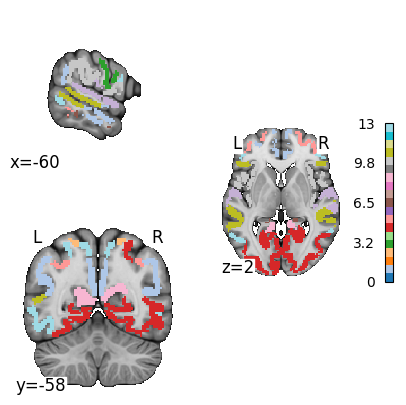

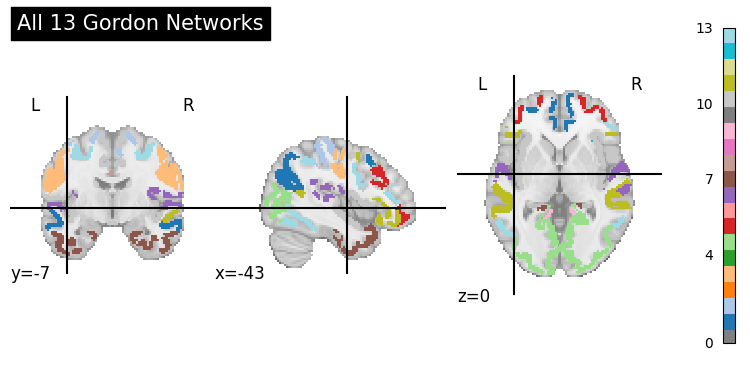

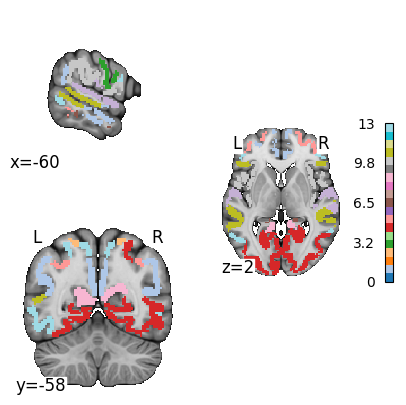

In [64]:
%matplotlib inline

from nilearn import plotting

# 1) Load your atlas
atlas_img = nib.load("./gordon_networks_222.nii")
atlas_data = atlas_img.get_fdata()

# 2) Find all unique labels (excluding background = 0)
region_ids = np.unique(atlas_data)
region_ids = region_ids[region_ids != 0]
print("Found region indices:", region_ids)

# This will map labels 1→13 into the first 13 colors of 'tab20'
plotting.plot_roi(
    atlas_img, title="All 13 Gordon Networks", cmap="tab20", colorbar=True, alpha=1
)

# This will map labels 1→13 into the first 13 colors of 'tab20'
plot_vol(
    atlas_img, cmap="tab20", threshold = 0
)



In [74]:
plot_surf("./gordon_networks_222.nii")

ValueError: The input type is not recognized. './gordon_networks_222.nii' was given while valid inputs are one of the following file formats: .gii, .gii.gz, Freesurfer specific files such as '.orig', '.pial', '.sphere', '.white', '.infla', two Numpy arrays organized in a list, tuple or a namedtuple with the fields "coordinates" and "faces".

## katie code

In [34]:
# importing the tools we'll use throughout the rest of the script
# sys is system tools, should already be installed
import sys
import json

# pandas is a dataframe-managing library and it's the absolute coolest
import pandas as pd

# numpy is short for "numerical python" and it does math
import numpy as np

# seaborn is a plotting library named after a character from West Wing
# it's kind of like python's ggplot
import seaborn as sns

# nibabel handles nifti images
import nibabel as nib

# os is more system tools, should also already be installed
# we're importing tools for verifying and manipulating file paths/directories
from os.path import join, exists, isdir
from os import makedirs

# nilearn makes the best brain plots
# and their documentation/examples are so, so handy
# https://nilearn.github.io/stable/auto_examples/01_plotting/index.html
from nilearn import plotting, surface, datasets

# matplotlib is the backbone of most python plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# gridspec helps us put lots of panels on one figure
from matplotlib.gridspec import GridSpec

In [ ]:
def assign_region_names(df, missing=False):
    """
    Input:
    df = dataframe (variable x columns) with column containing region names in ABCD var ontology,
    Output:
    df = same dataframe, but with column mapping region variables to actual region names
    missing = optional, list of ABCD region names not present in region_names dictionary
    """

    # read in region names
    with open(
        "/Volumes/projects_herting/LABDOCS/PROJECTS/ABCD/Data/release4.0/python_scripts/abcd_vars_to_region_names.json"
    ) as json_file:
        region_names = json.load(json_file)

    missing = []
    if not "long_region" in df.columns:
        df["measure"] = ""
        df["region"] = ""
        df["modality"] = ""
        df["atlas"] = ""
        df["long_region"] = ""
        df["hemisphere"] = ""
        for var in df.index:
            # print(var)
            if "mrisdp" in var:
                var_num = int(var.split(".")[0].split("_")[-1])
                df.at[var, "modality"] = "smri"
                df.at[var, "atlas"] = "dtx"
                if var_num <= 148:
                    df.at[var, "measure"] = "thick"
                elif var_num <= 450 and var_num >= 303:
                    df.at[var, "measure"] = "area"
                elif var_num < 604 and var_num >= 450:
                    df.at[var, "measure"] = "vol"
                elif var_num <= 1054 and var_num >= 907:
                    df.at[var, "measure"] = "t1wcnt"
                elif var_num == 604:
                    df.at[var, "measure"] = "gmvol"
            elif "_" in var:
                var_list = var.split(".")[0].split("_")
                df.at[var, "modality"] = var_list[0]
                df.at[var, "measure"] = var_list[1]
                df.at[var, "atlas"] = var_list[2]
                region = "_".join(var_list[3:])
                df.at[var, "region"] = region
                if "scs" in var:
                    if "rsirni" in var:
                        df.at[var, "measure"] = "rsirnigm"
                    elif "rsirnd" in var:
                        df.at[var, "measure"] = "rsirndgm"
                    else:
                        pass
                else:
                    pass
                if "_scs_" in region:
                    temp = region.split("_scs_")
                    region_name = (
                        f"{region_names[temp[0]][0]}, {region_names[temp[1]][0]}"
                    )
                    hemisphere = region_names[temp[1]][1]
                    df.at[var, "long_region"] = region_name
                    df.at[var, "hemisphere"] = hemisphere
                    df.at[var, "measure"] = "subcortical-network fc"
                elif "_ngd_" in region:
                    temp = region.split("_ngd_")
                    if temp[0] == temp[1]:
                        df.at[var, "measure"] = "within-network fc"
                    else:
                        df.at[var, "measure"] = "between-network fc"
                    region_name = (
                        f"{region_names[temp[0]][0]}, {region_names[temp[1]][0]}"
                    )
                    hemisphere = region_names[temp[1]][1]
                    df.at[var, "long_region"] = region_name
                    df.at[var, "hemisphere"] = hemisphere
                elif str(region) not in (region_names.keys()):
                    missing.append(region)
                else:
                    long_region = region_names[region]
                    df.at[var, "long_region"] = long_region[0]
                    df.at[var, "hemisphere"] = long_region[1]

        df = df[df["measure"] != "t1w"]
        df = df[df["measure"] != "t2w"]
    else:
        pass

    print(f"missed {len(missing)} regions bc they weren't in the dict")
    return df


def plot_surfaces(nifti, surf, cmap, vmax, threshold):
    """
    Plots of medial and lateral left and right surface views from nifti volume
    """
    texture_l = surface.vol_to_surf(nifti, surf.pial_left, interpolation="nearest")
    texture_r = surface.vol_to_surf(nifti, surf.pial_right, interpolation="nearest")

    fig = plt.figure(figsize=(12, 4))
    gs = GridSpec(1, 4)

    ax0 = fig.add_subplot(gs[0], projection="3d")
    ax1 = fig.add_subplot(gs[1], projection="3d")
    ax2 = fig.add_subplot(gs[2], projection="3d")
    ax3 = fig.add_subplot(gs[3], projection="3d")

    fig1 = plotting.plot_img_on_surf(
        nifti,
        cmap=cmap,
        threshold=threshold,
        # vmax=vmax,
        symmetric_cbar=True,
        kwargs={"bg_on_data": True, "alpha": 0.5, "avg_method": "max"},
        # output_file=f'../figures/{cols.name}.png'
    )

    plt.tight_layout(w_pad=-1, h_pad=-1)
    figure = plotting.plot_surf_stat_map(
        surf.pial_left,
        texture_l,
        bg_map=surf.sulc_left,
        symmetric_cbar=True,
        threshold=threshold,
        cmap=cmap,
        view="lateral",
        colorbar=False,
        vmax=vmax,
        axes=ax0,
    )
    figure = plotting.plot_surf_stat_map(
        surf.pial_left,
        texture_l,
        bg_map=surf.sulc_left,
        symmetric_cbar=True,
        threshold=threshold,
        cmap=cmap,
        view="medial",
        colorbar=False,
        vmax=vmax,
        axes=ax1,
    )
    figure = plotting.plot_surf_stat_map(
        surf.pial_right,
        texture_r,
        bg_map=surf.sulc_right,
        symmetric_cbar=True,
        threshold=threshold,
        cmap=cmap,
        view="lateral",
        colorbar=False,
        vmax=vmax,
        axes=ax2,
    )
    figure = plotting.plot_surf_stat_map(
        surf.pial_right,
        texture_r,
        bg_map=surf.sulc_right,
        symmetric_cbar=True,
        threshold=threshold,
        cmap=cmap,
        view="medial",
        colorbar=False,
        vmax=vmax,
        axes=ax3,
    )
    return figure, fig1


def series_2_nifti(series_in, out_dir, save=False):
    nifti_mapping = pd.read_pickle(
        "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/data/variable_to_nifti_mapping.pkl"
    )
    series = series_in.copy()
    series.index = [x.split(".")[0] for x in series.index]

    # vmin = series.quantile(0.25)

    # list of measures to plot
    measures = {
        "cortical-thickness": "smri_thick_cdk_.*",
        "cortical-gwcontrast": "smri_t1wcnt_cdk_.*",
        "cortical-area": "smri_area_cdk_.*",
        "cortical-volume": "smri_vol_cdk_.*",
        "subcortical-volume": "smri_vol_scs_.*",
        "subcortical-RND": "dmri_rsirnd_scs_.*",
        "subcortical-RNI": "dmri_rsirni_scs_.*",
        "cortical-RND": "dmri_rsirndgm_.*",
        "cortical-RNI": "dmri_rsirnigm_.*",
        "cortical-BOLD-variance": "rsfmri_var_cdk_.*",
        "tract-volume": "dmri_dtivol_fiberat_.*",
        "tract-FA": "dmri_dtifa_fiberat_.*",
        "tract-MD": "dmri_dtimd_fiberat_.*",
        "tract-LD": "dmri_dtild_fiberat_.*",
        "tract-TD": "dmri_dtitd_fiberat_.*",
        "tract-RND": "dmri_rsirnd_fib_.*",
        "tract-RNI": "dmri_rsirni_fib_.*",
    }
    fc_cort_var = series.filter(regex=".*fmri.*_c_.*").index
    fc_scor_var = series.filter(regex=".*fmri.*_cor_.*").index
    fmri_var_var = series.filter(regex=".*fmri.*_var_.*").index

    # morph_var = df[df['concept'] == 'macrostructure'].index
    # cell_var = df[df['concept'] == 'microstructure'].index
    func_var = list(fmri_var_var)
    conn_var = list(fc_cort_var) + list(fc_scor_var)

    conn_measures = {
        "cortical-network-connectivity": "rsfmri_c_ngd_.*",
        "subcortical-network-connectivity": "rsfmri_cor_ngd_.*_scs_.*",
    }

    # let's plot APC on brains pls
    for measure in measures.keys():
        # print(measure, measures[measure])
        # print(measure)

        meas_df = series.filter(regex=measures[measure], axis=0)
        meas_vars = meas_df.index

        # meas_df.drop_duplicates(inplace=True)
        # print(len(meas_df.index))
        # print(meas_df.head())
        if len(meas_df[meas_df != 0]) == 0:
            pass
        else:
            if "tract" in measure:
                # print('tract')
                fibers = nifti_mapping.filter(regex=measures[measure], axis=0).index
                var = fibers[0]
                tract_fname = nifti_mapping.loc[var]["atlas_fname"]
                tract_nii = nib.load(tract_fname)
                tract_arr = tract_nii.get_fdata()
                # print(np.unique(tract_arr))
                avg = series.loc[f"{var}"]
                tract_arr *= avg
                all_tracts_arr = np.zeros(tract_arr.shape)
                all_tracts_arr += tract_arr
                for var in fibers[1:]:
                    tract_fname = nifti_mapping.loc[var]["atlas_fname"]
                    if type(tract_fname) is str:
                        try:
                            tract_nii = nib.load(tract_fname)
                            tract_arr = tract_nii.get_fdata()
                            # print(np.unique(tract_arr))
                            avg = series.loc[f"{var}"]
                            tract_arr *= avg
                            all_tracts_arr += tract_arr
                        except Exception as e:
                            pass
                    else:
                        pass
                meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
                if save:
                    meas_nimg.to_filename(f"{out_dir}/{series.name}.nii")

            else:
                # print('cortex')
                # print(nifti_mapping.loc[meas_vars]['atlas_fname'])
                atlas_fname = nifti_mapping.loc[meas_vars]["atlas_fname"].unique()[0]
                # print(atlas_fname)
                atlas_nii = nib.load(atlas_fname)
                atlas_arr = atlas_nii.get_fdata()
                plotting_arr = np.zeros(atlas_arr.shape)
                for i in meas_df.index:
                    if i in nifti_mapping.index:
                        value = nifti_mapping.loc[i]["atlas_value"]

                        # print(i, value)
                        if value is np.nan:
                            pass

                        else:
                            val = series.at[i]
                            # print(avg, value, atlas_arr.shape)
                            plotting_arr[np.where(atlas_arr == value)] = val
                    else:
                        pass

                meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
                # print(np.mean(plotting_arr))
                if save:
                    meas_nimg.to_filename(f"{out_dir}/{series.name}.nii")

    return meas_nimg

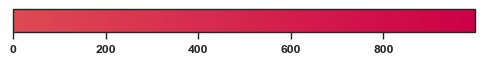

In [62]:
from matplotlib.colors import LinearSegmentedColormap
# Define the number of colors in the colormap
num_colors = 1000

# Define anchor points for key colors using hex values
colors1 = [
    "#26005c",  # Dark Blue
    "#274492",
]

# Create a smooth interpolation for the custom colormap
cmap1 = LinearSegmentedColormap.from_list("custom_cmap", colors1, N=num_colors)

# Define anchor points for key colors using hex values
colors2 = [
    "#29ccff",  # light blue
    "#8FCC66",  # green
]

# Create a smooth interpolation for the custom colormap
cmap2 = LinearSegmentedColormap.from_list("custom_cmap", colors2, N=num_colors)

# Define anchor points for key colors using hex values
colors3 = [
    "#dd4a53",  # Orange
    "#cc0047",  # Red
]

# Create a smooth interpolation for the custom colormap
cmap3 = LinearSegmentedColormap.from_list("custom_cmap", colors3, N=num_colors)

# Plot the color gradient
plt.figure(figsize=(8, 2))
plt.imshow([list(range(num_colors))], aspect="auto", cmap=cmap3)
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")
plt.show()

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_2028/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


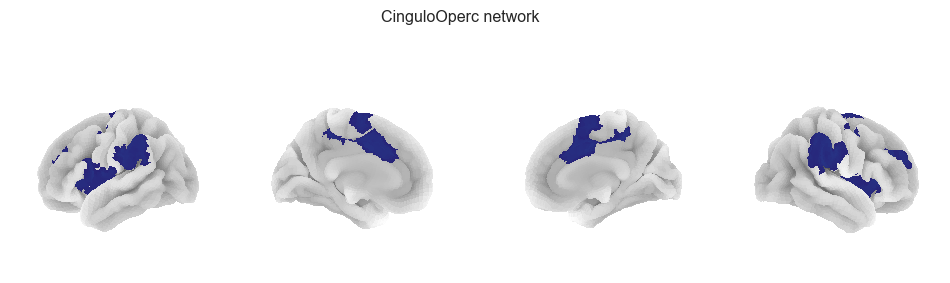

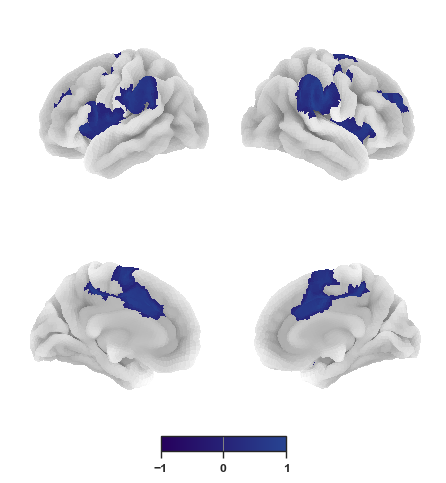

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_2028/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


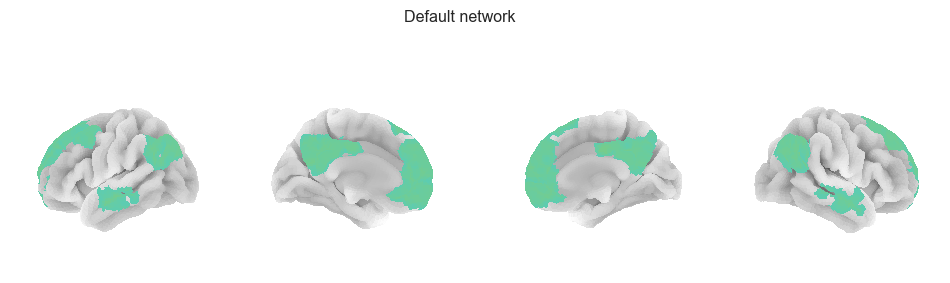

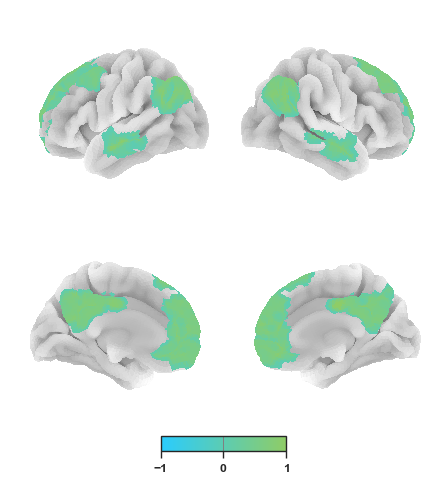

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_2028/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


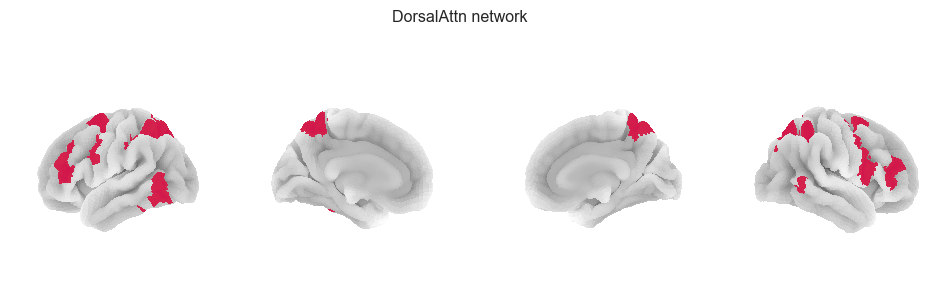

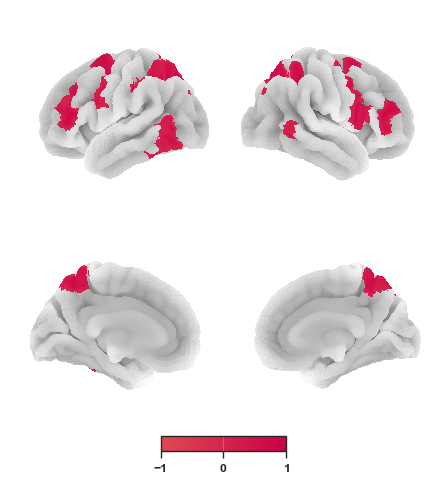

In [64]:
import numpy as np
import nibabel as nib
from nilearn import datasets

# fetch once
surf = datasets.fetch_surf_fsaverage()

# load your full Gordon atlas
img = nib.load("./gordon_networks_222.nii")
data = img.get_fdata()
affine = img.affine
hdr = img.header

# the three networks you care about
networks = [10, 1, 13]
network_map = {10: "CinguloOperc", 1: "Default", 13: "DorsalAttn"}
colors = [cmap1, cmap2, cmap3]

for net, color in zip(networks, colors):
    # create a binary mask: 1 where data==net, 0 elsewhere
    mask_vol = (data == net).astype(np.uint8)
    mask_img = nib.Nifti1Image(mask_vol, affine, hdr)

    # plot it
    fig_stat, fig_img = plot_surfaces(
        nifti=mask_img,
        surf=surf,
        cmap=color,  # any cmap is fine for binary
        vmax=1,  # since mask only has 0 & 1
        threshold=0.01,  # hides the zeros
    )
    fig_stat.suptitle(f"{network_map[net]} network", y=0.9)
    plt.show()

## Plot LME

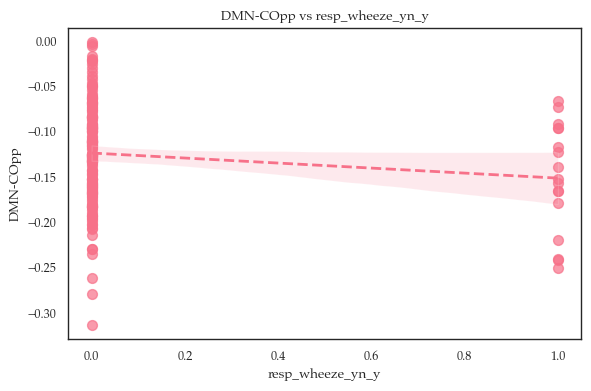

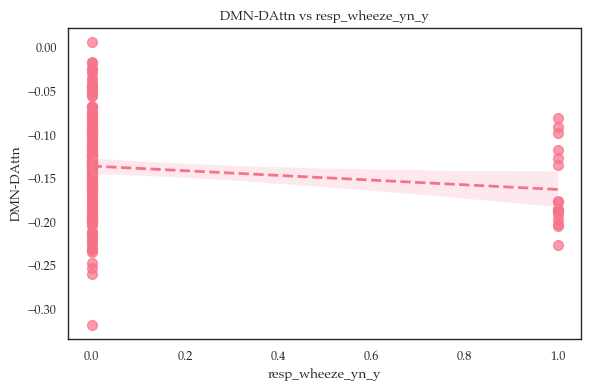

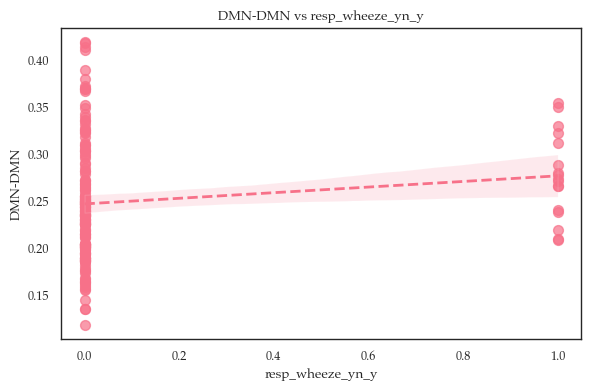

In [18]:
REG_DIR = "./derivatives/regression"

# Set global font properties
plt.rcParams["font.family"] = "Palatino"  # Change to the desired font
plt.rcParams["font.weight"] = "bold"  # Set all fonts to bold

reg_df = pd.read_csv(join(REG_DIR, "regression.csv"))

rsfc_reg_measures = [
    "rsfmri_c_ngd_cgc_ngd_dt",
    "rsfmri_c_ngd_dt_ngd_dla",
    "rsfmri_c_ngd_dt_ngd_dt",
]

# renamed the abide 2 phenotypes
rsfc_map = {
    "rsfmri_c_ngd_cgc_ngd_dt": "DMN-COpp",
    "rsfmri_c_ngd_dt_ngd_dla": "DMN-DAttn",
    "rsfmri_c_ngd_dt_ngd_dt": "DMN-DMN",
}

phyhealth_col = "resp_wheeze_yn_y"

for measure in rsfc_reg_measures:
    pretty = rsfc_map.get(measure, measure)

    plt.figure(figsize=(6, 4))
    sns.regplot(
        x=phyhealth_col,
        y=measure,
        data=reg_df,
        scatter_kws={"alpha": 0.7, "s": 50},
        line_kws={"linewidth": 2, "ls": "--"},
    )
    plt.xlabel(phyhealth_col, weight="bold")
    plt.ylabel(pretty, weight="bold")
    plt.title(f"{pretty} vs {phyhealth_col}", weight="bold")
    plt.tight_layout()
    plt.show()